In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta

from sklearn.base import clone
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

import os
import sys
sys.path.append(os.path.join(os.path.abspath(''), '..'))
from utils.transformer import WaveletTransformer
from utils.kernels import generalized_cone_kernel

sns.set_theme('notebook', 'whitegrid', 'dark')

In [2]:
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
groups_train = np.load('../data/groups_train.npy')
severities_train = np.load('../data/severities_train.npy')

In [3]:
def create_kernel(gamma, beta):
    def kernel(X, Y):
        return generalized_cone_kernel(X, Y, gamma, beta)
    return kernel

pipeline = Pipeline([
    ('wavelet_transformer', WaveletTransformer(w_list=[83, 130, 1435], n_samples=100, n_frequencies=20)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=12)),
    ('svm', SVC(probability=True, kernel=create_kernel(0.7686, 6.190), C=50))
])

pipeline.fit(X_train, y_train);

In [4]:
y_pred_train = pipeline.predict(X_train)
y_pred_proba_train = pipeline.predict_proba(X_train)

In [5]:
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
groups_test = np.load('../data/groups_test.npy')
severities_test = np.load('../data/severities_test.npy')

In [6]:
y_pred_test = pipeline.predict(X_test)
y_pred_proba_test = pipeline.predict_proba(X_test)

Accuracy: 90.70%
AUC ROC: 0.97


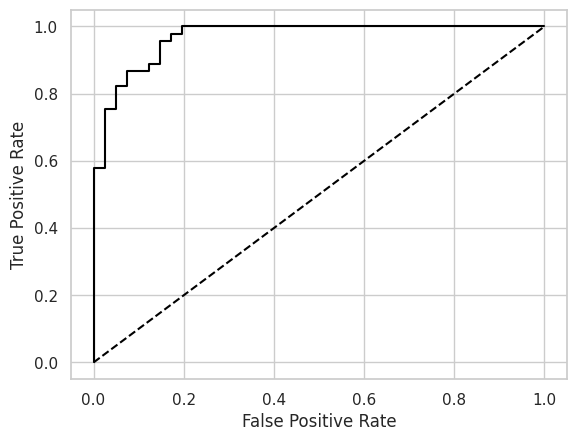

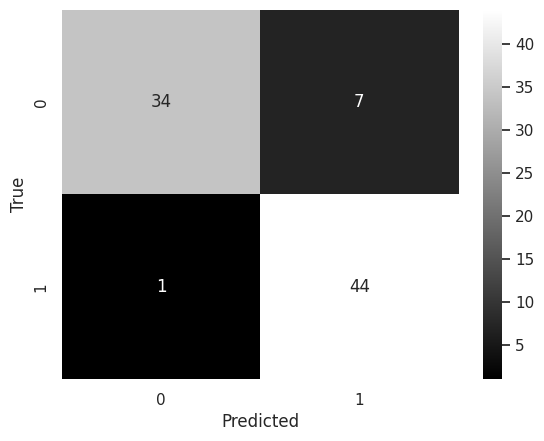

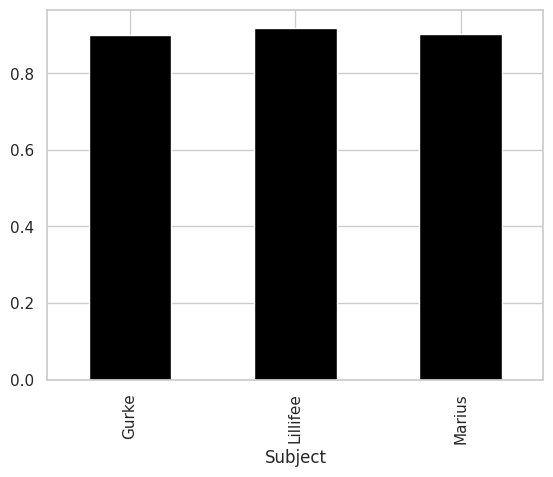

In [7]:
accuracy = np.mean(y_pred_test == y_test)
print(f'Accuracy: {accuracy:.2%}')

auc_roc = roc_auc_score(y_test, y_pred_proba_test[:, 1])
print(f'AUC ROC: {auc_roc:.2f}')

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test[:, 1])
plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, cmap='grey')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

df = pd.DataFrame({'y': y_test, 'y_pred': y_pred_test, 'Subject': groups_test})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

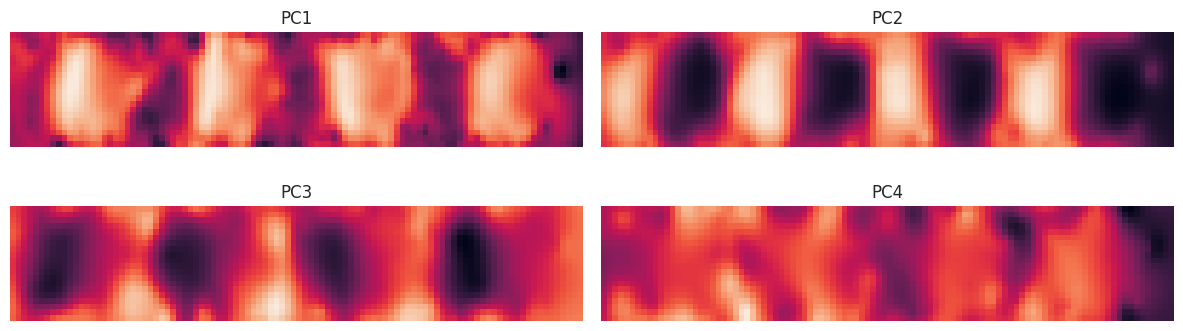

In [8]:
pca = pipeline.named_steps['pca']

num_plots = min(4, len(pca.components_))
num_cols = 2
num_rows = (num_plots + 1)//num_cols
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(6*num_cols, 2*num_rows))

for row in range(num_rows):
    for col in range(num_cols):
        idx = row*num_cols + col
        if idx >= num_plots:
            break
        pc = pca.components_[idx]
        pc = np.moveaxis(pc.reshape(-1, 20, 100), 0, -1)
        axes[row, col].imshow(pc[:,:,0])
        axes[row, col].set_title('PC' + str(idx + 1))
        axes[row, col].axis('off')

fig.tight_layout()
plt.show()

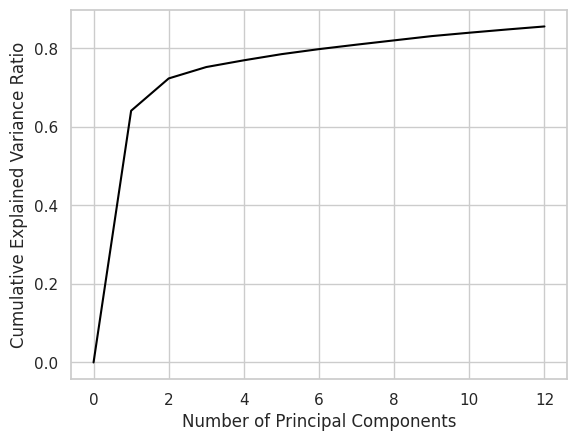

In [9]:
cumulative_explained_variance_ratio = np.concatenate((np.zeros(1), pca.explained_variance_ratio_)).cumsum()
num_components = len(cumulative_explained_variance_ratio)
plt.plot(range(0, num_components), cumulative_explained_variance_ratio, color='black')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.show()

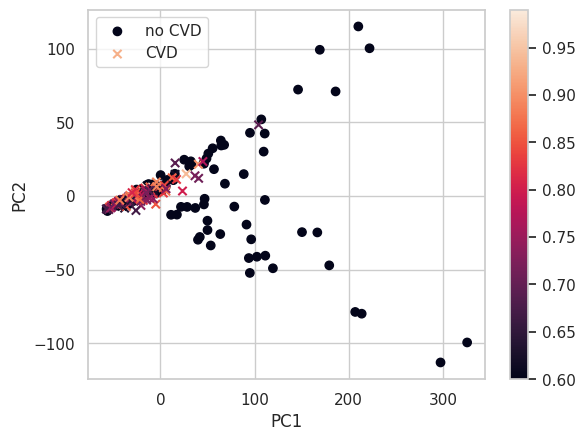

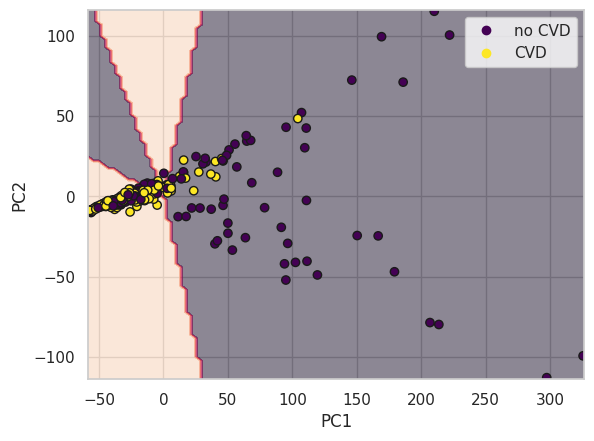

In [10]:
X_pca = pipeline.named_steps['wavelet_transformer'].transform(X_train)
X_pca = pipeline.named_steps['scaler'].transform(X_pca)
X_pca = pipeline.named_steps['pca'].transform(X_pca)

markers = ['o', 'x']
for i, marker in enumerate(markers):
    plt.scatter(X_pca[y_train == i, 0], X_pca[y_train == i, 1], marker=marker, label='CVD' if i == 1 else 'no CVD', c=np.array(severities_train)[y_train == i])

plt.legend()
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

X_reduced = X_pca[:,:2]

model = clone(pipeline.named_steps['svm'])

model.fit(X_reduced, y_train)
disp = DecisionBoundaryDisplay.from_estimator(
    model, X_reduced, response_method="predict",
    xlabel='PC1', ylabel='PC2',
    alpha=0.5,
)
scatter = disp.ax_.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_train, edgecolors='k', cmap='viridis')
disp.ax_.legend(handles=scatter.legend_elements()[0], labels=['no CVD', 'CVD'])
plt.show()

In [14]:
X_cvd = np.load('../data/X_cvd.npy')
y_cvd = np.load('../data/y_cvd.npy')
groups_cvd = np.load('../data/groups_cvd.npy')

X_cvd = X_cvd[y_cvd == 0]
groups_cvd = groups_cvd[y_cvd == 0]
y_cvd = np.abs(y_cvd[y_cvd == 0] - 1)

In [15]:
y_pred_cvd = pipeline.predict(X_cvd)
y_pred_proba_cvd = pipeline.predict_proba(X_cvd)

Accuracy: 82.05%


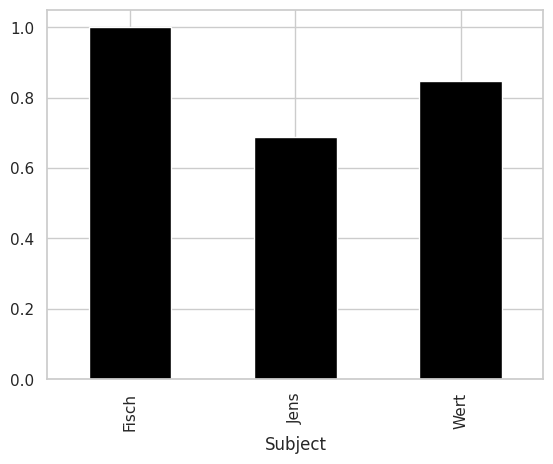

In [21]:
accuracy = np.mean(y_pred_cvd == y_cvd)
print(f'Accuracy: {accuracy:.2%}')

df = pd.DataFrame({'y': y_cvd, 'y_pred': y_pred_cvd, 'Subject': groups_cvd})
df['correct'] = df['y'] == df['y_pred']
df.groupby('Subject').mean()['correct'].plot(kind='bar', color='black');

Not Simulated
a: 0.24, b: 1.04


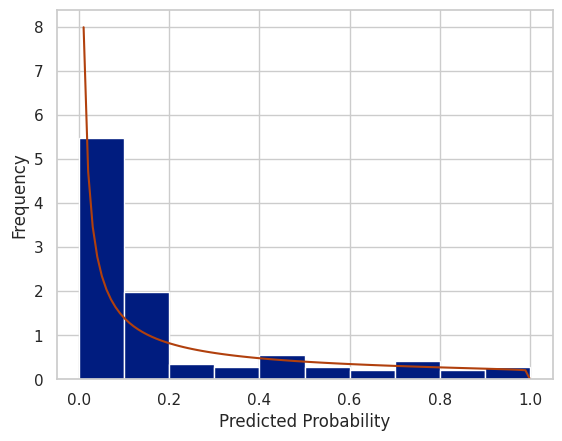

Simulated
a: 1.86, b: 0.40


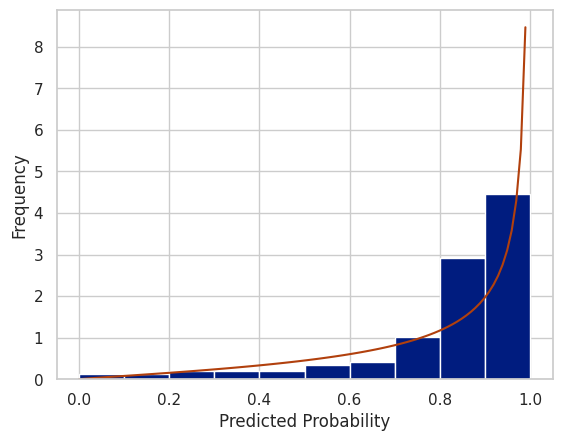

CVD


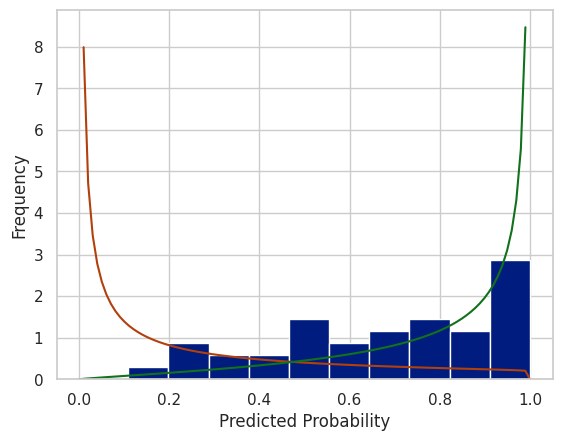

In [22]:
simulated = y_pred_proba_train[y_train == 1][:, 1]
not_simulated = y_pred_proba_train[y_train == 0][:, 1]

simulated = np.concatenate((simulated, np.linspace(0, 1, 20)))
not_simulated = np.concatenate((not_simulated, np.linspace(0, 1, 20)))

mu_not_simulated = np.mean(not_simulated)
sigma_not_simulated = np.std(not_simulated)
a_not_simulated = mu_not_simulated*(mu_not_simulated*(1-mu_not_simulated)/sigma_not_simulated**2 - 1)
b_not_simulated = (1-mu_not_simulated)*(mu_not_simulated*(1-mu_not_simulated)/sigma_not_simulated**2 - 1)

mu_simulated = np.mean(simulated)
sigma_simulated = np.std(simulated)
a_simulated = mu_simulated*(mu_simulated*(1-mu_simulated)/sigma_simulated**2 - 1)
b_simulated = (1-mu_simulated)*(mu_simulated*(1-mu_simulated)/sigma_simulated**2 - 1)

print('Not Simulated')
print(f'a: {a_not_simulated:.2f}, b: {b_not_simulated:.2f}')
plt.hist(not_simulated, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_not_simulated, b_not_simulated))
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

print('Simulated')
print(f'a: {a_simulated:.2f}, b: {b_simulated:.2f}')
plt.hist(simulated, density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_simulated, b_simulated))
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

print('CVD')
plt.hist(y_pred_proba_cvd[:, 1], density=True)
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_not_simulated, b_not_simulated))
plt.plot(np.linspace(0, 1, 100), beta.pdf(np.linspace(0, 1, 100), a_simulated, b_simulated))
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()

Subject: Marius, Accuracy: 86.67%
Log Likelihood No CVD: 32.90381137649239
Log Likelihood CVD: -68.92936836217318
Likelihood Ratio: 5.948561621616163e-45
No CVD


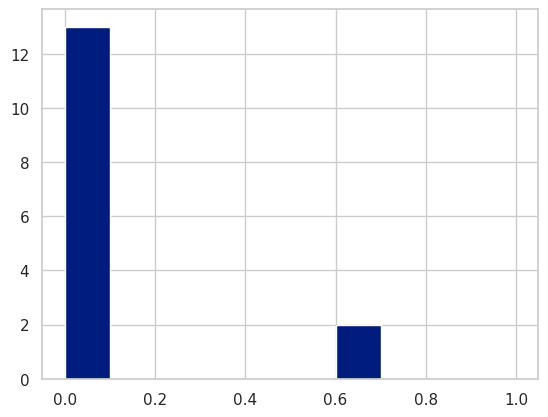

Subject: Lillifee, Accuracy: 81.82%
Log Likelihood No CVD: 5.958695295115604
Log Likelihood CVD: -28.530020266858276
Likelihood Ratio: 1.0513350502294295e-15
No CVD


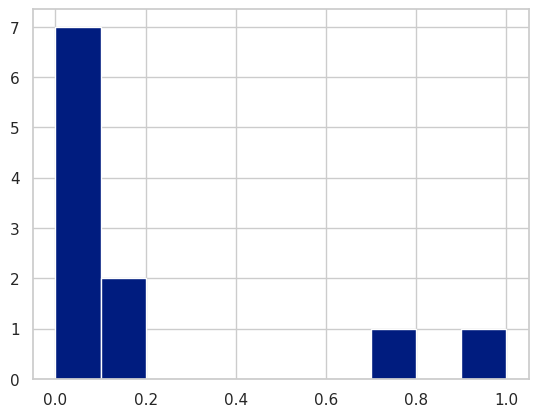

Subject: Gurke, Accuracy: 80.00%
Log Likelihood No CVD: 8.722501205659547
Log Likelihood CVD: -40.31306497117884
Likelihood Ratio: 5.059693301095354e-22
No CVD


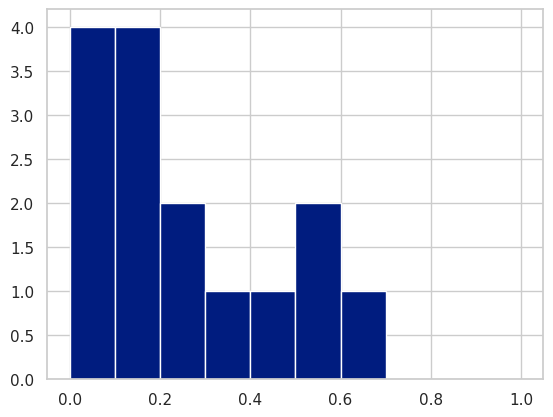

Subject: Fisch, Accuracy: 100.00%
Log Likelihood No CVD: -19.860397621895093
Log Likelihood CVD: 82.37853338838
Likelihood Ratio: 2.522339688342038e+44
CVD


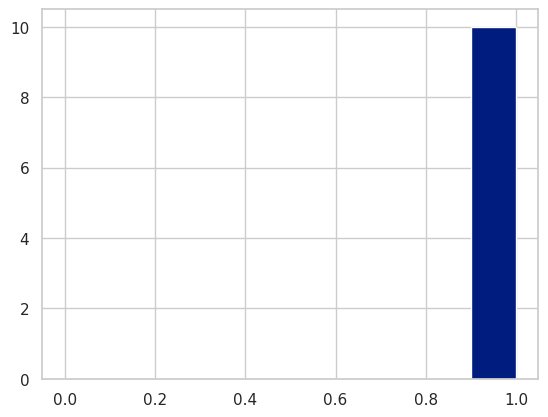

Subject: Wert, Accuracy: 84.62%
Log Likelihood No CVD: -13.082706914200639
Log Likelihood CVD: -6.776571156625954
Likelihood Ratio: 547.923543237521
CVD


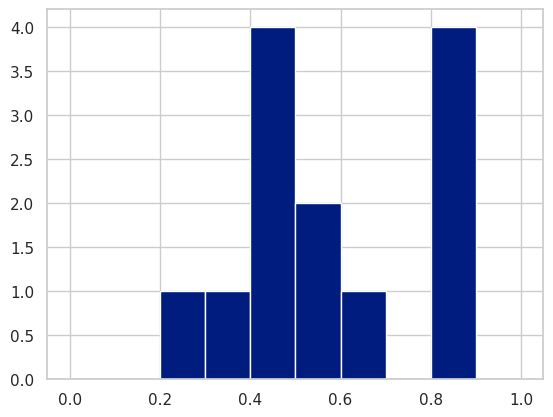

Subject: Jens, Accuracy: 68.75%
Log Likelihood No CVD: -15.143494462661463
Log Likelihood CVD: -9.27814461840304
Likelihood Ratio: 352.6054915390581
CVD


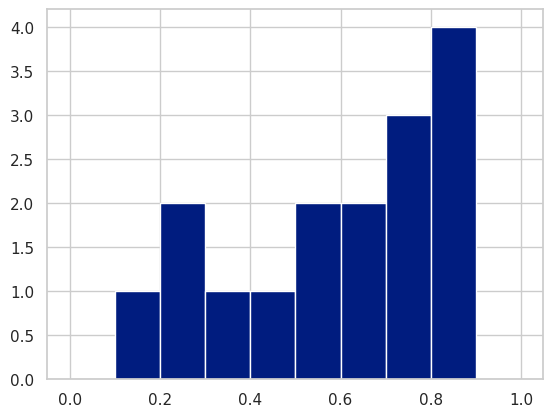

In [20]:
for group in set(groups_test):
    y_group_pred = y_pred_test[np.logical_and(groups_test == group, y_test == 0)]
    y_group_pred_proba = y_pred_proba_test[np.logical_and(groups_test == group, y_test == 0)]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred == 0):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_not_simulated, b_not_simulated))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_simulated, b_simulated))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    print(f'Likelihood Ratio: {np.exp(log_likelihood_cvd - log_likelihood_no_cvd)}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()

for group in set(groups_cvd):
    y_group_pred = y_pred_cvd[groups_cvd == group]
    y_group_pred_proba = y_pred_proba_cvd[groups_cvd == group]
    print(f'Subject: {group}, Accuracy: {np.mean(y_group_pred):.2%}')
    log_likelihood_no_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_not_simulated, b_not_simulated))
    log_likelihood_cvd = np.sum(beta.logpdf(y_group_pred_proba[:, 1], a_simulated, b_simulated))
    print(f'Log Likelihood No CVD: {log_likelihood_no_cvd}')
    print(f'Log Likelihood CVD: {log_likelihood_cvd}')
    print(f'Likelihood Ratio: {np.exp(log_likelihood_cvd - log_likelihood_no_cvd)}')
    if log_likelihood_no_cvd > log_likelihood_cvd:
        print('No CVD')
    else:
        print('CVD')
        
    plt.hist(y_group_pred_proba[:, 1], range=(0, 1))
    plt.show()